<center>
  <a href="https://imgbb.com/"><img src="https://i.ibb.co/gwD1XY2/eurisko-logo-white-2x-png1.png" alt="eurisko-logo-white-2x-png1" border="0" /></a>
</center>
<font size=10><center>Data Analytics and AI</center></font>
<font size=6><center>Project - Deep Learning - NLP - Week 4</center>

# Project NLP Classification: Resume Classification at TechCorp
**Points: 100**

## Context:
TechCorp, a leading technology company, receives thousands of resumes every month for various job openings. The HR department faces a significant challenge in manually reviewing and shortlisting candidates, which is both time-consuming and prone to human error. Automating this process can enhance efficiency and accuracy, ensuring that the best candidates are quickly identified for **the right** job position.

## Objective:
In this assignment, you will play the role of an NLP engineer at TechCorp, tasked with developing a deep learning model to automate resume classification. Using data available online in text format, you will preprocess and clean resumes to train a model that predicts the best-matching job position based on labels of that you choose/find. This involves several steps, from data collection and preprocessing to model training and evaluation.

## Key Requirements:
- **Data Collection**: Collect/augment open source labeled text data about CVs.
- **Data Preprocessing**: Preporcess the data to fit the needed task.
- **Model Class:** Encapsulate your model within a class structure for training.
- **Evaluation Techniques:** Apply proper evaluation methods to assess your  model's classification performance.
- **README File:** Include a README file detailing the data source, preprocessing steps, model details, results, and key insights such as strengths and weaknesses.
- **Documentation:** Ensure clear documentation with explanations and comments for each function or class. Add your explanation in this Jupyter Notebook
- **Checkpoint:** Save your best model checkpoint on your drive. Share the folder of the checkpoint through google drive to our email "ai@eurisko.net" so we can evaluate your model.

### Bonus:
- For a fun test, try applying your own CV to your trained model. If your CV is in PDF format, use a PDF parser (e.g., PyPDF2, PyMuPDF, pdfminer) to convert it to text. Ensure you preprocess the text appropriately before feeding it into your model.


In [1]:
import pandas as pd
import seaborn as sns
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import scipy.sparse as sp
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from transformers import AutoTokenizer
import torch
from datasets import Dataset, DatasetDict, load_metric, load_dataset
from transformers import AutoModelForSequenceClassification, BertConfig, BertForSequenceClassification
from transformers import Trainer, TrainingArguments, pipeline
import numpy as np
import evaluate


In [2]:
pip install evaluate datasets

In [3]:
# Load the CSV file
file_path = '/content/UpdatedResumeDataSet.csv'
resume_data = pd.read_csv(file_path)

# Display the first few rows of the dataframe
resume_data.head()

Category                                             Resume
0  Data Science  Skills * Programming Languages: Python (pandas...
1  Data Science  Education Details \nMay 2013 to May 2017 B.E  ...
2  Data Science  Areas of Interest Deep Learning, Control Syste...
3  Data Science  Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...
4  Data Science  Education Details \n MCA   YMCAUST,  Faridabad...

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
dataset2 = load_dataset("ahmedheakl/resume-atlas")
# Step 1: Add __index_level_0__ column
dataset2['train'] = dataset2['train'].add_column('__index_level_0__', list(range(len(dataset2['train']))))

# Step 2: Rename Text column to Resume
dataset2['train'] = dataset2['train'].rename_column('Text', 'Resume')

# Display the updated dataset structure
print(dataset2)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


DatasetDict({
    train: Dataset({
        features: ['Category', 'Resume', '__index_level_0__'],
        num_rows: 13389
    })
})


In [6]:
# Convert the Hugging Face dataset to a pandas DataFrame
df3 = pd.DataFrame(dataset2['train'])

# Get unique values in the 'Category' column
unique_categories = df3['Category'].unique()

# Display the unique values
print(unique_categories)

['Accountant' 'Advocate' 'Agriculture' 'Apparel' 'Architecture' 'Arts'
 'Automobile' 'Aviation' 'Banking' 'Blockchain' 'BPO'
 'Building and Construction' 'Business Analyst' 'Civil Engineer'
 'Consultant' 'Data Science' 'Database' 'Designing' 'DevOps'
 'Digital Media' 'DotNet Developer' 'Education' 'Electrical Engineering'
 'ETL Developer' 'Finance' 'Food and Beverages' 'Health and Fitness'
 'Human Resources' 'Information Technology' 'Java Developer' 'Management'
 'Mechanical Engineer' 'Network Security Engineer' 'Operations Manager'
 'PMO' 'Public Relations' 'Python Developer' 'React Developer' 'Sales'
 'SAP Developer' 'SQL Developer' 'Testing' 'Web Designing']


In [7]:
category_mapping = {
    'Accountant': 'Accountant',
    'Advocate': 'Advocate',
    'Agriculture': 'Agriculture',
    'Apparel': 'Apparel',
    'Architecture': 'Architecture',
    'Arts': 'Arts',
    'Automobile': 'Automobile',
    'Aviation': 'Aviation',
    'Banking': 'Banking',
    'Blockchain': 'Blockchain',
    'BPO': 'BPO',
    'Building and Construction': 'Building and Construction',
    'Business Analyst': 'Business Analyst',
    'Civil Engineer': 'Civil Engineer',
    'Consultant': 'Consultant',
    'Data Science': 'Data Science',
    'Database': 'Database',
    'Designing': 'Designing',
    'DevOps': 'DevOps Engineer',
    'Digital Media': 'Digital Media',
    'DotNet Developer': 'DotNet Developer',
    'Education': 'Education',
    'Electrical Engineering': 'Electrical Engineering',
    'ETL Developer': 'ETL Developer',
    'Finance': 'Finance',
    'Food and Beverages': 'Food and Beverages',
    'Health and Fitness': 'Health and fitness',
    'Human Resources': 'HR',
    'Information Technology': 'Information Technology',
    'Java Developer': 'Java Developer',
    'Management': 'Management',
    'Mechanical Engineer': 'Mechanical Engineer',
    'Network Security Engineer': 'Network Security Engineer',
    'Operations Manager': 'Operations Manager',
    'PMO': 'PMO',
    'Public Relations': 'Public Relations',
    'Python Developer': 'Python Developer',
    'React Developer': 'React Developer',
    'Sales': 'Sales',
    'SAP Developer': 'SAP Developer',
    'SQL Developer': 'SQL Developer',
    'Testing': 'Automation Testing',
    'Web Designing': 'Web Designing'
}

# Apply the category mapping
df3['Category'] = df3['Category'].replace(category_mapping)

# Display the unique values in the 'Category' column
unique_categories = df3['Category'].unique()
print(unique_categories)

['Accountant' 'Advocate' 'Agriculture' 'Apparel' 'Architecture' 'Arts'
 'Automobile' 'Aviation' 'Banking' 'Blockchain' 'BPO'
 'Building and Construction' 'Business Analyst' 'Civil Engineer'
 'Consultant' 'Data Science' 'Database' 'Designing' 'DevOps Engineer'
 'Digital Media' 'DotNet Developer' 'Education' 'Electrical Engineering'
 'ETL Developer' 'Finance' 'Food and Beverages' 'Health and fitness' 'HR'
 'Information Technology' 'Java Developer' 'Management'
 'Mechanical Engineer' 'Network Security Engineer' 'Operations Manager'
 'PMO' 'Public Relations' 'Python Developer' 'React Developer' 'Sales'
 'SAP Developer' 'SQL Developer' 'Automation Testing' 'Web Designing']


In [8]:
combined_data = pd.concat([resume_data, df3], ignore_index=True)
combined_data = combined_data.drop(columns=['__index_level_0__'])
print(combined_data)

            Category                                             Resume
0       Data Science  Skills * Programming Languages: Python (pandas...
1       Data Science  Education Details \nMay 2013 to May 2017 B.E  ...
2       Data Science  Areas of Interest Deep Learning, Control Syste...
3       Data Science  Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...
4       Data Science  Education Details \n MCA   YMCAUST,  Faridabad...
...              ...                                                ...
14346  Web Designing  jessica claire montgomery street san francisco...
14347  Web Designing  jessica claire montgomery street san francisco...
14348  Web Designing  summary jessica claire 100 montgomery st 10th ...
14349  Web Designing  jessica claire montgomery street san francisco...
14350  Web Designing  websites portfolios profiles professional summ...

[14351 rows x 2 columns]


In [9]:
# Split the dataset into training and testing sets
train_df, test_df = train_test_split(combined_data, test_size=0.2, random_state=42)

In [10]:
# Convert these sets into Dataset objects
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

In [11]:
combined_data.isnull().sum()

Category    0
Resume      0
dtype: int64

In [12]:
# Combine them into a DatasetDict
dataset_dict = DatasetDict({
    'train': train_dataset,
    'test': test_dataset
})
print(dataset_dict)
print(dataset_dict['train'][0])

DatasetDict({
    train: Dataset({
        features: ['Category', 'Resume', '__index_level_0__'],
        num_rows: 11480
    })
    test: Dataset({
        features: ['Category', 'Resume', '__index_level_0__'],
        num_rows: 2871
    })
})
{'Category': 'Sales', 'Resume': 'jessica claire montgomery street san francisco ca 94105 555 4321000 resumesampleexamplecom summary enthusiastic reliable well organized office assistant solid background data entry communication telephone customer service skills ability manage daily office functions strength managing multiple projects simultaneously highlights professional mature attitude appearance professional phone etiquette excellent communication skills effective time management organization multitasking skills quick learn dependable ability work independently collaboratively customer service oriented detail oriented ability work pressure meet strict deadlines multiline phone proficiency filing data archiving data entry familiarity microsoft

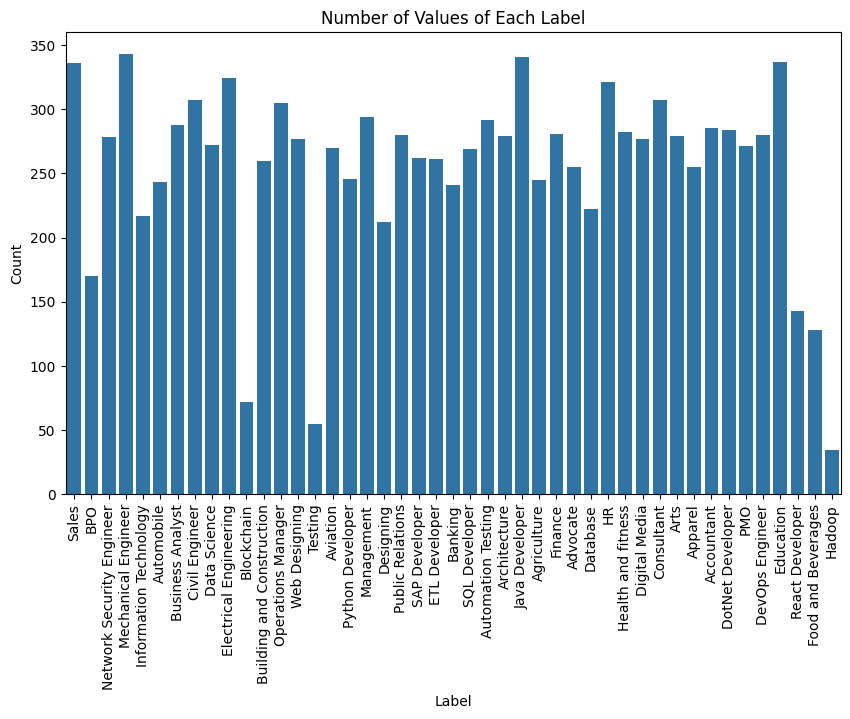

In [13]:
df = dataset_dict['train'].to_pandas()

plt.figure(figsize=(10, 6))
sns.countplot(x='Category', data=df)
plt.title('Number of Values of Each Label')
plt.xticks(rotation=90)
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

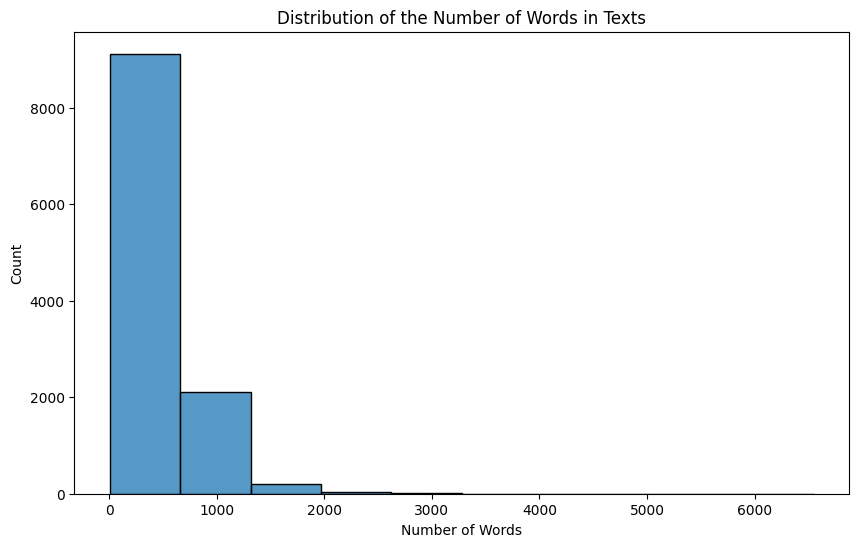

In [14]:
# Calculate the number of words in each text
df['num_words'] = df['Resume'].apply(lambda x: len(x.split()))

# Plot the distribution of the number of words
plt.figure(figsize=(10, 6))
sns.histplot(df['num_words'], bins=10, kde=False)
plt.title('Distribution of the Number of Words in Texts')
plt.xlabel('Number of Words')
plt.ylabel('Count')
plt.show()

In [15]:
def clean_text(text):
    # Remove multiple spaces, newlines, and special characters
    text = re.sub(r'\s+', ' ', text)  # Replace multiple whitespace characters with a single space
    text = re.sub(r'[^\w\s]', '', text)  # Remove special characters (optional, modify as needed)
    text = text.strip()  # Remove leading and trailing whitespace
    return text

In [16]:
from transformers import BertTokenizer


tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [17]:
df = df[df['Category'] != 'Testing']

In [18]:
df['Category'].unique()

array(['Sales', 'BPO', 'Network Security Engineer', 'Mechanical Engineer',
       'Information Technology', 'Automobile', 'Business Analyst',
       'Civil Engineer', 'Data Science', 'Electrical Engineering',
       'Blockchain', 'Building and Construction', 'Operations Manager',
       'Web Designing', 'Aviation', 'Python Developer', 'Management',
       'Designing', 'Public Relations', 'SAP Developer', 'ETL Developer',
       'Banking', 'SQL Developer', 'Automation Testing', 'Architecture',
       'Java Developer', 'Agriculture', 'Finance', 'Advocate', 'Database',
       'HR', 'Health and fitness', 'Digital Media', 'Consultant', 'Arts',
       'Apparel', 'Accountant', 'DotNet Developer', 'PMO',
       'DevOps Engineer', 'Education', 'React Developer',
       'Food and Beverages', 'Hadoop'], dtype=object)

Let us remove all the non tech categories that we probably wont need in our company

In [19]:
non_tech_categories = [
    'Sales', 'BPO', 'Mechanical Engineer', 'Automobile', 'Civil Engineer',
    'Building and Construction', 'Operations Manager', 'Public Relations',
    'Banking', 'Architecture', 'Agriculture', 'Finance', 'Advocate',
    'Health and fitness', 'Consultant', 'Arts', 'Apparel', 'Accountant',
    'Food and Beverages'
]
df = df[~df['Category'].isin(non_tech_categories)]

# Display the first few rows to verify
print(df['Category'].unique())
print()

['Network Security Engineer' 'Information Technology' 'Business Analyst'
 'Data Science' 'Electrical Engineering' 'Blockchain' 'Web Designing'
 'Aviation' 'Python Developer' 'Management' 'Designing' 'SAP Developer'
 'ETL Developer' 'SQL Developer' 'Automation Testing' 'Java Developer'
 'Database' 'HR' 'Digital Media' 'DotNet Developer' 'PMO'
 'DevOps Engineer' 'Education' 'React Developer' 'Hadoop']



In [20]:
label2id = {
    'Network Security Engineer': 0,
    'Information Technology': 1,
    'Business Analyst': 2,
    'Data Science': 3,
    'Electrical Engineering': 4,
    'Blockchain': 5,
    'Web Designing': 6,
    'Testing': 7,
    'Aviation': 8,
    'Python Developer': 9,
    'Management': 10,
    'Designing': 11,
    'SAP Developer': 12,
    'ETL Developer': 13,
    'SQL Developer': 14,
    'Automation Testing': 15,
    'Java Developer': 16,
    'Database': 17,
    'HR': 18,
    'Digital Media': 19,
    'DotNet Developer': 20,
    'PMO': 21,
    'DevOps Engineer': 22,
    'Education': 23,
    'React Developer': 24,
    'Hadoop': 25
}
id2label = {v: k for k, v in label2id.items()}

In [21]:
pip install nlpaug

In [22]:
## Input
### Import libraries
import pandas as pd
import random
from nlpaug.augmenter.word import SynonymAug, AntonymAug, RandomWordAug, SpellingAug
from sklearn.model_selection import train_test_split

syn_aug = SynonymAug(aug_src='wordnet')
ant_aug = AntonymAug()
random_aug = RandomWordAug(action="swap")
spell_aug = SpellingAug()

def augment_text(text):
    augmenters = [syn_aug, ant_aug, random_aug, spell_aug]
    aug = random.choice(augmenters)
    return aug.augment(text)

def balance_data(df, target_count):
    balanced_df = pd.DataFrame(columns=df.columns)

    for label in df['Category'].unique():
        label_df = df[df['Category'] == label]
        current_count = len(label_df)

        if current_count < target_count:
            # Augment data
            augmentations_needed = target_count - current_count
            augmented_texts = []
            print(f"Augmenting {label} from {current_count} to {target_count}...")
            for i in range(augmentations_needed):
                text_to_augment = label_df['Resume'].sample(n=1).values[0]
                augmented_texts.append(augment_text(text_to_augment))
                if (i + 1) % 100 == 0:
                    print(f"Augmented {i + 1}/{augmentations_needed} texts for {label}")

            augmented_df = pd.DataFrame({
                'Resume': augmented_texts,
                'Category': [label] * augmentations_needed
            })
            label_df = pd.concat([label_df, augmented_df])

        elif current_count > target_count:
            # Randomly sample data
            label_df = label_df.sample(n=target_count, random_state=42)

        balanced_df = pd.concat([balanced_df, label_df])

    return balanced_df

## Model
# Balance the dataset
df_train = pd.DataFrame(df)
df = balance_data(df_train, 500)

Augmenting Network Security Engineer from 278 to 500...
Augmented 100/222 texts for Network Security Engineer
Augmented 200/222 texts for Network Security Engineer


<ipython-input-22-572d58e52f1c>:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_df = pd.concat([balanced_df, label_df])


Augmenting Information Technology from 217 to 500...
Augmented 100/283 texts for Information Technology
Augmented 200/283 texts for Information Technology
Augmenting Business Analyst from 288 to 500...
Augmented 100/212 texts for Business Analyst
Augmented 200/212 texts for Business Analyst
Augmenting Data Science from 272 to 500...
Augmented 100/228 texts for Data Science
Augmented 200/228 texts for Data Science
Augmenting Electrical Engineering from 324 to 500...
Augmented 100/176 texts for Electrical Engineering
Augmenting Blockchain from 72 to 500...
Augmented 100/428 texts for Blockchain
Augmented 200/428 texts for Blockchain
Augmented 300/428 texts for Blockchain
Augmented 400/428 texts for Blockchain
Augmenting Web Designing from 277 to 500...
Augmented 100/223 texts for Web Designing
Augmented 200/223 texts for Web Designing
Augmenting Aviation from 270 to 500...
Augmented 100/230 texts for Aviation
Augmented 200/230 texts for Aviation
Augmenting Python Developer from 246 to 50

In [23]:
# Ensure the column names are correct
df = df[['Resume','Category']]
df


Resume  \
2    jessica claire montgomery street san francisco...   
17   marcus hall network security engineer 98296876...   
79   evan edward security engineer contact inforesu...   
104  experience education skills elwyn mayert 8125 ...   
157  jessica claire resumesampleexamplecom 555 4321...   
..                                                 ...   
461  [Areas of expertise â  ¢ Big Data Ecosystems:...   
462  [Areas of expertise â  ¢ Big Data Ecosystems:...   
463  [Skill Set: Hadoop, Map Reduce, HDFS, Hive Sqo...   
464  [Skill Set: Hadoop, Map Reduce, HDFS, Hive, Sq...   
465  [Technical Skill Set: Programming Languages Ap...   

                      Category  
2    Network Security Engineer  
17   Network Security Engineer  
79   Network Security Engineer  
104  Network Security Engineer  
157  Network Security Engineer  
..                         ...  
461                     Hadoop  
462                     Hadoop  
463                     Hadoop  
464                     Hadoop  
465                     Hadoop  

[12500 rows x 2 columns]

In [28]:
def preprocess_function(examples):
    # Ensure all elements are strings
    examples['Resume'] = [clean_text(str(text)) for text in examples['Resume']]

    # Tokenize resumes
    tokenized_examples = tokenizer(examples['Resume'], truncation=True, padding='max_length', max_length=128)

    # Convert labels to ids
    labels = [label2id.get(label, -1) for label in examples['Category']]  # Use .get() to handle unknown labels
    tokenized_examples['labels'] = labels
    return tokenized_examples
# some of the resumes were turned into lists while aumenting so i just join them back
df['Resume'] = df['Resume'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)
train_dataset = Dataset.from_pandas(df)
# Apply the preprocessing to the dataset

train_dataset = train_dataset.map(preprocess_function, batched=True)

df_test = pd.DataFrame(dataset_dict['test'])
df_test = df_test[~df_test['Category'].isin(non_tech_categories)]
df_test = df_test[['Resume','Category']]
test_dataset = Dataset.from_pandas(df_test)
test_dataset = test_dataset.map(preprocess_function, batched=True)

# Verify the changes
# print(preprocessed_dataset['train'].column_names)

Map:   0%|          | 0/12500 [00:00<?, ? examples/s]

Map:   0%|          | 0/1622 [00:00<?, ? examples/s]

In [29]:
train_dataset = train_dataset.shuffle(seed=42).select(range(12500))
test_dataset = test_dataset.shuffle(seed=42).select(range(1622))

Training the model

In [31]:
print(train_dataset)
print(test_dataset)

Dataset({
    features: ['Resume', 'Category', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
    num_rows: 12500
})
Dataset({
    features: ['Resume', 'Category', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
    num_rows: 1622
})


In [32]:
model_name = 'bert-base-uncased'
config = BertConfig.from_pretrained('bert-base-uncased', num_labels=26, id2label=id2label, label2id=label2id)
model = BertForSequenceClassification.from_pretrained(model_name, config=config)
print(model)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [33]:
model.config.id2label = id2label
model.config.label2id = label2id


In [34]:
if torch.cuda.is_available():
    model = model.cuda()

In [35]:
torch.cuda.is_available()


True

In [36]:

train_df = pd.DataFrame(train_dataset)
train_df = train_df.drop(columns=['__index_level_0__'])
filteredtrain_df = train_df[train_df['labels'] != -1]
train_df = Dataset.from_pandas(filteredtrain_df)

test_df = pd.DataFrame(test_dataset)
filteredtest_df = test_df[test_df['labels'] != -1]
test_df = Dataset.from_pandas(filteredtest_df)

training_args = TrainingArguments(
    output_dir="trainer_output",
    eval_strategy="epoch"
    , num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    logging_dir='./logs',
    logging_strategy='epoch'
    )

metric = evaluate.load("accuracy")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    # # Convert label IDs to label names
    predictions_labels = [id2label[pred] for pred in predictions]
    references_labels = [id2label[ref] for ref in labels]
    return metric.compute(predictions=predictions, references=labels)

model.to(device)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)
trainer.train()

TrainOutput(global_step=3910, training_loss=0.35287459390547576, metrics={'train_runtime': 1537.573, 'train_samples_per_second': 40.648, 'train_steps_per_second': 2.543, 'total_flos': 4111996128000000.0, 'train_loss': 0.35287459390547576, 'epoch': 5.0})

We should have stopped at epoch 3 since not much changed and it was starting to overfit

In [37]:
train_df

Dataset({
    features: ['Resume', 'Category', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
    num_rows: 12500
})

In [38]:
trainer.evaluate()

{'eval_loss': 0.7622029185295105,
 'eval_accuracy': 0.8674475955610358,
 'eval_runtime': 12.0183,
 'eval_samples_per_second': 134.961,
 'eval_steps_per_second': 8.487,
 'epoch': 5.0}

In [39]:
# Use the trainined model for inference
custom_classifier = pipeline("text-classification", model=model, tokenizer=tokenizer, truncation = True)

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [40]:
pip install pdfplumber

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.5/48.5 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.0/58.0 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 91.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 61.7 MB/s eta 0:00:00


In [41]:
import pdfplumber

def pdf_to_text(pdf_path):
    text = ""
    # Open the PDF file
    with pdfplumber.open(pdf_path) as pdf:
        # Iterate through each page
        for page in pdf.pages:
            text += page.extract_text()

    return text

pdf_path = '/content/Gabriel ELKHOURY - CV.pdf'
text = pdf_to_text(pdf_path)
text = clean_text(text)
# Classify the cleaned text
result = custom_classifier(text)
print(result)


[{'label': 'Web Designing', 'score': 0.8542018532752991}]


In [42]:
import pdfplumber

def pdf_to_text(pdf_path):
    text = ""
    # Open the PDF file
    with pdfplumber.open(pdf_path) as pdf:
        # Iterate through each page
        for page in pdf.pages:
            text += page.extract_text()

    return text

pdf_path = '/content/CharbelDaherCV p.pdf'
text = pdf_to_text(pdf_path)
text = clean_text(text)
# Classify the cleaned text
result = custom_classifier(text)
print(result)


[{'label': 'Data Science', 'score': 0.8153717517852783}]


In [43]:
def pdf_to_text(pdf_path):
    text = ""
    # Open the PDF file
    with pdfplumber.open(pdf_path) as pdf:
        # Iterate through each page
        for page in pdf.pages:
            text += page.extract_text()

    return text

pdf_path = '/content/Joelle Abdallah cv.pdf'
text = pdf_to_text(pdf_path)
text = clean_text(text)
# Classify the cleaned text
result = custom_classifier(text)
print(result)

[{'label': 'Web Designing', 'score': 0.9880896210670471}]


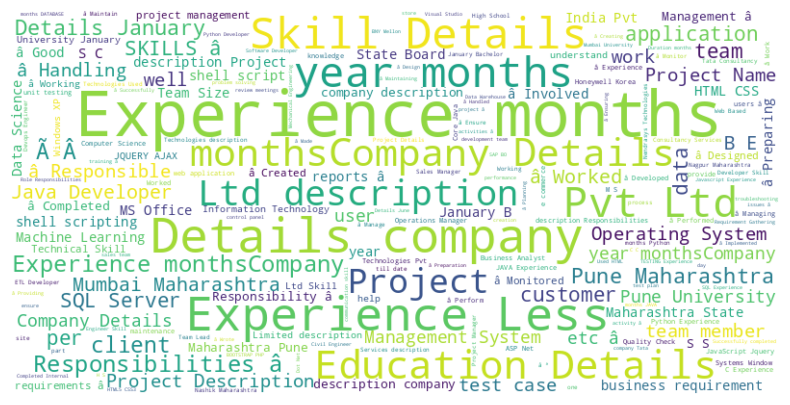

In [44]:
# Generate the word cloud
text = ' '.join(resume_data['Resume'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
from google.colab import drive
import shutil
import os

def copy_folder_to_drive(source_folder, destination_folder):
    # Mount Google Drive
    drive.mount('/content/drive')

    # Define the source and destination paths
    source = source_folder
    destination = os.path.join('/content/drive/MyDrive', destination_folder)

    # Remove the destination folder if it already exists
    if os.path.exists(destination):
        shutil.rmtree(destination)
    # Copy the folder from Colab workspace to Google Drive
    shutil.copytree(source, destination)

    print(f"Folder '{source}' has been copied to '{destination}'.")

# Define your source and destination folders
source_folder = '/content/trainer_output/'
destination_folder = 'trainer_output'

# Copy the folder
copy_folder_to_drive(source_folder, destination_folder)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
